In [1]:
# For changing directories to C++ programming and runnning files
import subprocess as sp
import os

# since using WSL2
os.environ['MPLCONFIGDIR'] = '/tmp/'

from multiprocessing import Pool

# Typical functionality for data manipulation and generation of latin hypercube
import numpy as np
from pyDOE import lhs
import emcee

# Gaussian Process emulator 
import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.gaussian_process import kernels as krnl
import scipy.special as special
import scipy.stats as st
from scipy import optimize
from scipy.linalg import lapack

# for plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import seaborn as sns
sns.set("notebook")
%matplotlib inline
plt.style.use('default')

# data storage
import pandas as pd
import pickle


In [2]:
import sys
print(sys.platform)

linux


In [3]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [4]:
# My costumizations for plots
import matplotlib.font_manager
from matplotlib import rc
rc('font',**{'family':'serif', 'serif':['Computer Modern Roman']})
rc('text', usetex=True)

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def costumize_axis(ax, x_title, y_title):
    ax.set_xlabel(x_title, fontsize=24)
    ax.set_ylabel(y_title, fontsize=24)
    ax.tick_params(axis='both', labelsize=18, top=True, right=True)
    ax.tick_params(axis='both', which='major', direction='in', length=8)
    ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.tick_params(axis='both', which='minor', direction='in', length=4, top=True, right=True)
    return ax

In [5]:
# Others costumizations for plots
def hist_1d_2d(X, Y, nameX, nameY):
    left, width = 0.1, 0.75
    bottom, height = 0.1, 0.75
    spacing = 0.005
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.15]
    rect_histy = [left + width + spacing, bottom, 0.15, height]

    fig = plt.figure(figsize=(10, 10))
    fig.patch.set_facecolor('white')
    ax = fig.add_axes(rect_scatter)
    ax1 = fig.add_axes(rect_histx, sharex=ax)
    ax2 = fig.add_axes(rect_histy, sharey=ax)
    costumize_axis(ax1, '', '')
    costumize_axis(ax2, '', '')
    ax1.tick_params(axis="x", labelbottom=False)
    ax2.tick_params(axis="y", labelleft=False)

    ax.scatter(X, Y, color='blue')
    ax1.hist(X, color='blue', density=True)
    ax2.hist(Y, color='blue', orientation='horizontal', density=True)
    costumize_axis(ax, nameX, nameY)

# Defining the Model
This was actually done in `C++`, and this bit of code interface with the executable.

In [6]:
def PrintParametersFile(params_dict):
    '''
    Function ouputs file "params.txt" to the Code/util folder to be used by the
    Code/build/exact_solution.x program
    '''
    os.chdir('/mnt/c/users/gil-c/Documents/Heinz_Research/TeX-Docs/Rough-Drafts/Bayesian-Toy-Model/Code/')
    with open('./utils/params.txt', 'w') as fout:
        fout.write(f'tau_0 {params_dict["tau_0"]}\n')
        fout.write(f'Lambda_0 {params_dict["Lambda_0"]}\n')
        fout.write(f'alpha_0 {params_dict["alpha_0"]}\n')
        fout.write(f'xi_0 {params_dict["xi_0"]}\n')
        fout.write(f'ul {params_dict["tau_f"]}\n')
        fout.write(f'll {params_dict["tau_0"]}\n')
        fout.write(f'mass {params_dict["mass"]}\n')
        fout.write(f'eta_s {params_dict["eta_s"]}\n')
        fout.write(f'pl0 {params_dict["pl0"]}\n')
        fout.write(f'pt0 {params_dict["pt0"]}\n')
        fout.write(f'TYPE {params_dict["hydro_type"]}')
    os.chdir('/mnt/c/users/gil-c/Documents/Heinz_Research/TeX-Docs/Rough-Drafts/Bayesian-Toy-Model/Code/scripts/')
    return 

def RunHydroSimulation():
    '''
    Function calls the C++ excecutable that run hydro calculations
    '''
    os.chdir('../')
    sp.run(['./build/exact_solution.x'], shell=True)
    os.chdir('scripts/')
    return

In [7]:
#default values for parameters
params = {
    'tau_0': 0.1,
    'Lambda_0': 1.647204044,
    'xi_0': -0.8320365099,
    'alpha_0': 0.654868759,
    'tau_f': 12.1,
    'mass': 1.015228426,
    'eta_s': 0.23873241463784,
    'pl0': 8.1705525351457684,
    'pt0': 1.9875332965147663,
    'hydro_type': 0
}

In [9]:
# function run runs hydro code to generate simualtion results for a set of 
# given parameters
def ProcessHydro(parameter_names, simulation_points, store_whole_file=False):
    out_list = []
    def GetFromOutputFiles(hydro_type):
        if hydro_type == 0:
            prefix = '../output/CE_hydro/'
            suffix = ''
        elif hydro_type == 1:
            prefix = '../output/DNMR_hydro/'
            suffix = ''
        elif hydro_type == 2:
            prefix = '../output/aniso_hydro/'
            suffix = ''
        elif hydro_type == 3:
            prefix = '../output/aniso_hydro/'
            suffix = '2'
        
        if store_whole_file:
            f_e = open(prefix + 'e' + suffix + '_m=0.200GeV.dat', 'r').readlines()
            f_pi = open(prefix + 'shear' + suffix + '_m=0.200GeV.dat', 'r').readlines()
            f_Pi = open(prefix + 'bulk' + suffix + '_m=0.200GeV.dat', 'r').readlines()
            
            out_list = []
            for i in range(len(f_e)):
                tau, e, pi, Pi = f_e[i].split()[0], f_e[i].split()[1], f_pi[i].split()[1], f_Pi[i].split()[1]
                out_list.append([float(tau), float(e), float(pi), float(Pi)])

            return np.array(out_list)
        else:
            f_e = open(prefix + 'e' + suffix + '_m=0.200GeV.dat', 'r')
            last_e = f_e.readlines()[-1]
            tau, e = last_e.split()[0], last_e.split()[1]
            f_e.close(); del last_e

            f_pi = open(prefix + 'shear' + suffix + '_m=0.200GeV.dat', 'r')
            last_pi = f_pi.readlines()[-1]
            pi = last_pi.split()[1]
            f_pi.close(); del last_pi

            f_Pi = open(prefix + 'bulk' + suffix + '_m=0.200GeV.dat', 'r')
            last_Pi = f_Pi.readlines()[-1]
            Pi = last_Pi.split()[1]
            f_Pi.close(); del last_Pi

            temp_list = [float(tau), float(e), float(pi), float(Pi)]
            return np.array(temp_list)

    def GetExactResults():
        f_exact = open('../output/exact/MCMC_calculation_moments.dat','r')
        if store_whole_file:
            return f_exact.readlines()
        else:
            t, e, pl, pt, p = f_exact.readlines()[-1].split()
            pi = (float(pt) - float(pl)) / 1.5
            Pi = (2 *  float(pt) + float(pl)) / 3 - float(p)
            temp_list = [float(t), float(e), pi, Pi]
            return temp_list

    if len(simulation_points) > len(parameter_names):
        for parameters in simulation_points:
            for i, name in enumerate(parameter_names):
                params[name] = parameters[i]
            PrintParametersFile(params)
            RunHydroSimulation()
            if params['hydro_type'] == 4:
                out_list.append(GetExactResults())
            else:
                out_list.append(GetFromOutputFiles(params['hydro_type']))

    else:
        for i, name in enumerate(parameter_names):
            params[name] = simulation_points[i]
        PrintParametersFile(params)
        RunHydroSimulation()
        if params['hydro_type'] == 4:
            return np.array(GetExactResults())
        else:
            return np.array(GetFromOutputFiles(params['hydro_type']))

    return np.array(out_list)


# Gaussian Process Regression
The training points and validation plots

In [10]:
# simulation times for generation of psuedo data
simulation_taus = np.array([5.1, 6.1, 7.1, 8.1, 9.1, 10.1, 11.1, 12.1])
eta_s = 5.0 / (4 * np.pi)
params['eta_s'] = eta_s
params['hydro_type'] = 4;
exact_out = []

read_in_exact = True
if read_in_exact:
    with open('exact_output_various_times.dat','r') as f:
        exact_out = np.array([[float(entry) for entry in line.split()] for line in f.readlines()])
else:

    # Need to improve to run calculation once, and then back track to the points we want to keep
    for i, tau in enumerate(simulation_taus):
        exact_out.append(ProcessHydro(['tau_f'], [tau]))
    
    with open('exact_output_various_times.dat','w') as f:
        for i, tau in enumerate(simulation_taus):
            for entry in exact_out[i]:
                f.write(f'{entry} ')
            if i != simulation_taus.size - 1:
                f.write('\n')



In [11]:
# Need to define latin hypercube sampling points and then run hydrodynamic simulation for all.
GP_parameter_names = ['eta_s','tau_0', 'Lambda_0', 'alpha_0', 'xi_0'] # Expand as needed
GP_parameter_names_math = [r'$\eta_s$', r'$\tau_0$', r'$\Lambda_0$', r'$\alpha_0$', r'$\xi_0$'] # Expand as needed
num_parameters_in_GP = len(GP_parameter_names) # Should be minimum of two to take into account relaxation time constant and ending time
# Make sure that order of ranges variable matches how they appear in names_of_GP_parameters
GP_parameter_ranges = np.array([[1 / (4 * np.pi), 10 / (4 * np.pi)], [0.05, 0.15], [0.0, 5.0], [0.0, 2.0], [-1.0, 10.0]])
num_design_points = 40 * num_parameters_in_GP
unit = lhs(n=num_parameters_in_GP, samples=num_design_points, criterion='maximin')
GP_design_points = GP_parameter_ranges[:, 0] + unit * (GP_parameter_ranges[:, 1] - GP_parameter_ranges[:, 0])
GP_design_range = GP_parameter_ranges[:,1] - GP_parameter_ranges[:,0]
print(GP_design_range)

[ 0.71619724  0.1         5.          2.         11.        ]


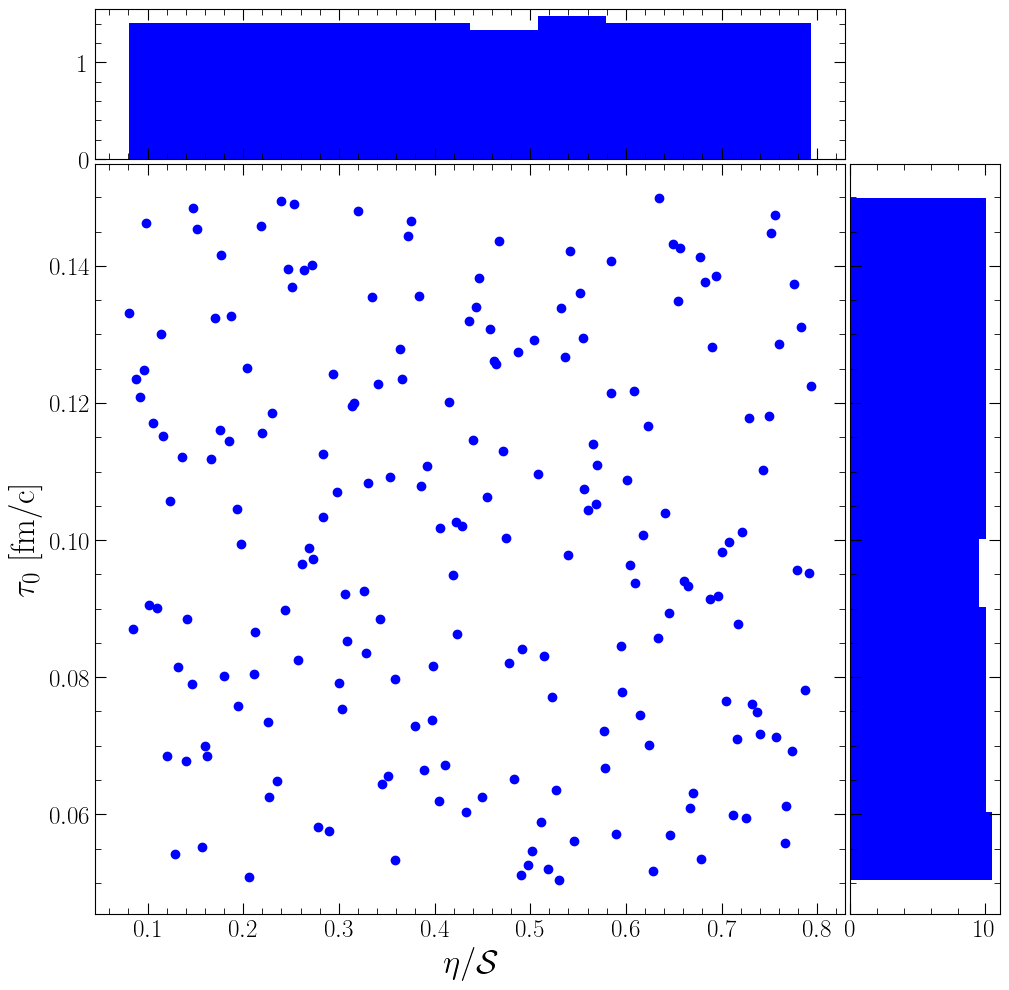

In [19]:
# fig, ax = plt.subplots(figsize=(10, 10))
# fig.patch.set_facecolor('white')
# ax.scatter(GP_design_points[:, 0], GP_design_points[:, 1])
# costumize_axis(ax, r'$\eta/\mathcal S$', r'$\tau_f$ [fm/c]')

hist_1d_2d(GP_design_points[:, 0], GP_design_points[:, 1], r'$\eta/\mathcal S$', r'$\tau_0$ [fm/c]')

In [26]:
# ce = []    # 0
# dnmr = []  # 1
# vah = []   # 2
# mvah = []  # 3
hydro_mode = [0, 1, 2, 3]
names = ['ce', 'dnmr', 'vah', 'mvah']
read_in_simulation = True   # should false for first run
if read_in_simulation:
    with open('design_points_n=4.dat','r') as f:
        GP_design_points = np.array([[float(entry) for entry in line.split()] for line in f.readlines()])

    hydro_lists = dict((key, []) for key in names)

    for j, tau in enumerate(simulation_taus):
        for name in names:
            with open(f'{name}_simulation_points_n=4_tau={tau}.dat', 'r') as f:
                lines = f.readlines()
                hydro_lists[name].append(np.array([[float(entry) for entry in line.split()] for line in lines]))

    full_simulations = dict((key, []) for key in names)
    for k, name in enumerate(names):
        for i, design_point in enumerate(GP_design_points):
            with open(f'full_outputs/{name}_full_output_C={design_point}_n=4.dat', 'r') as f:
                for line in f.readlines():
                    temp = []
                    for entry in line.split():
                        temp.append(float(entry))
                    full_simulations[name].append(temp)
else:
    global_last_output = dict((key, []) for key in names)
    global_full_output = dict((key, []) for key in names)
    
    params['tau_f'] = simulation_taus[-1]

    for i in range(4):
        params['hydro_type'] = i
        for design_point in GP_design_points:

            tau_start = design_point[1] # starting time 
            delta_tau = tau_start / 20
            stop_time_indices = np.floor((simulation_taus - np.full_like(simulation_taus, tau_start)) / delta_tau)

            local_last_output = []
            hydro_output = np.array(ProcessHydro(parameter_names=GP_parameter_names, simulation_points=design_point, store_whole_file=True))
            for j in range(simulation_taus.size):
                local_last_output.append(hydro_output[int(stop_time_indices[j]), :])
            global_last_output[names[i]].append(local_last_output)
            global_full_output[names[i]].append(hydro_output)   

    print(os.getcwd())
    with open('design_points_n=4.dat','w') as f:
        for line in GP_design_points:
            for entry in line:
                f.write(f'{entry} ')
            f.write(f'\n')

    for k, name in enumerate(names):
        for j, tau in enumerate(simulation_taus):
                with open(f'{name}_simulation_points_n=4_tau={tau}.dat', 'w') as f:
                    for line in np.array(global_last_output[name])[:, j, :]:
                        for entry in line:
                            f.write(f'{entry} ')
                        f.write('\n')

    for k, name in enumerate(names):
        for i, design_point in enumerate(GP_design_points):
            with open(f'full_outputs/{name}_full_output_C={design_point}_n=4.dat', 'w') as f:
                for line in global_full_output[name][i]:
                    for entry in line:
                        f.write(f'{entry} ')
                    f.write('\n')
    

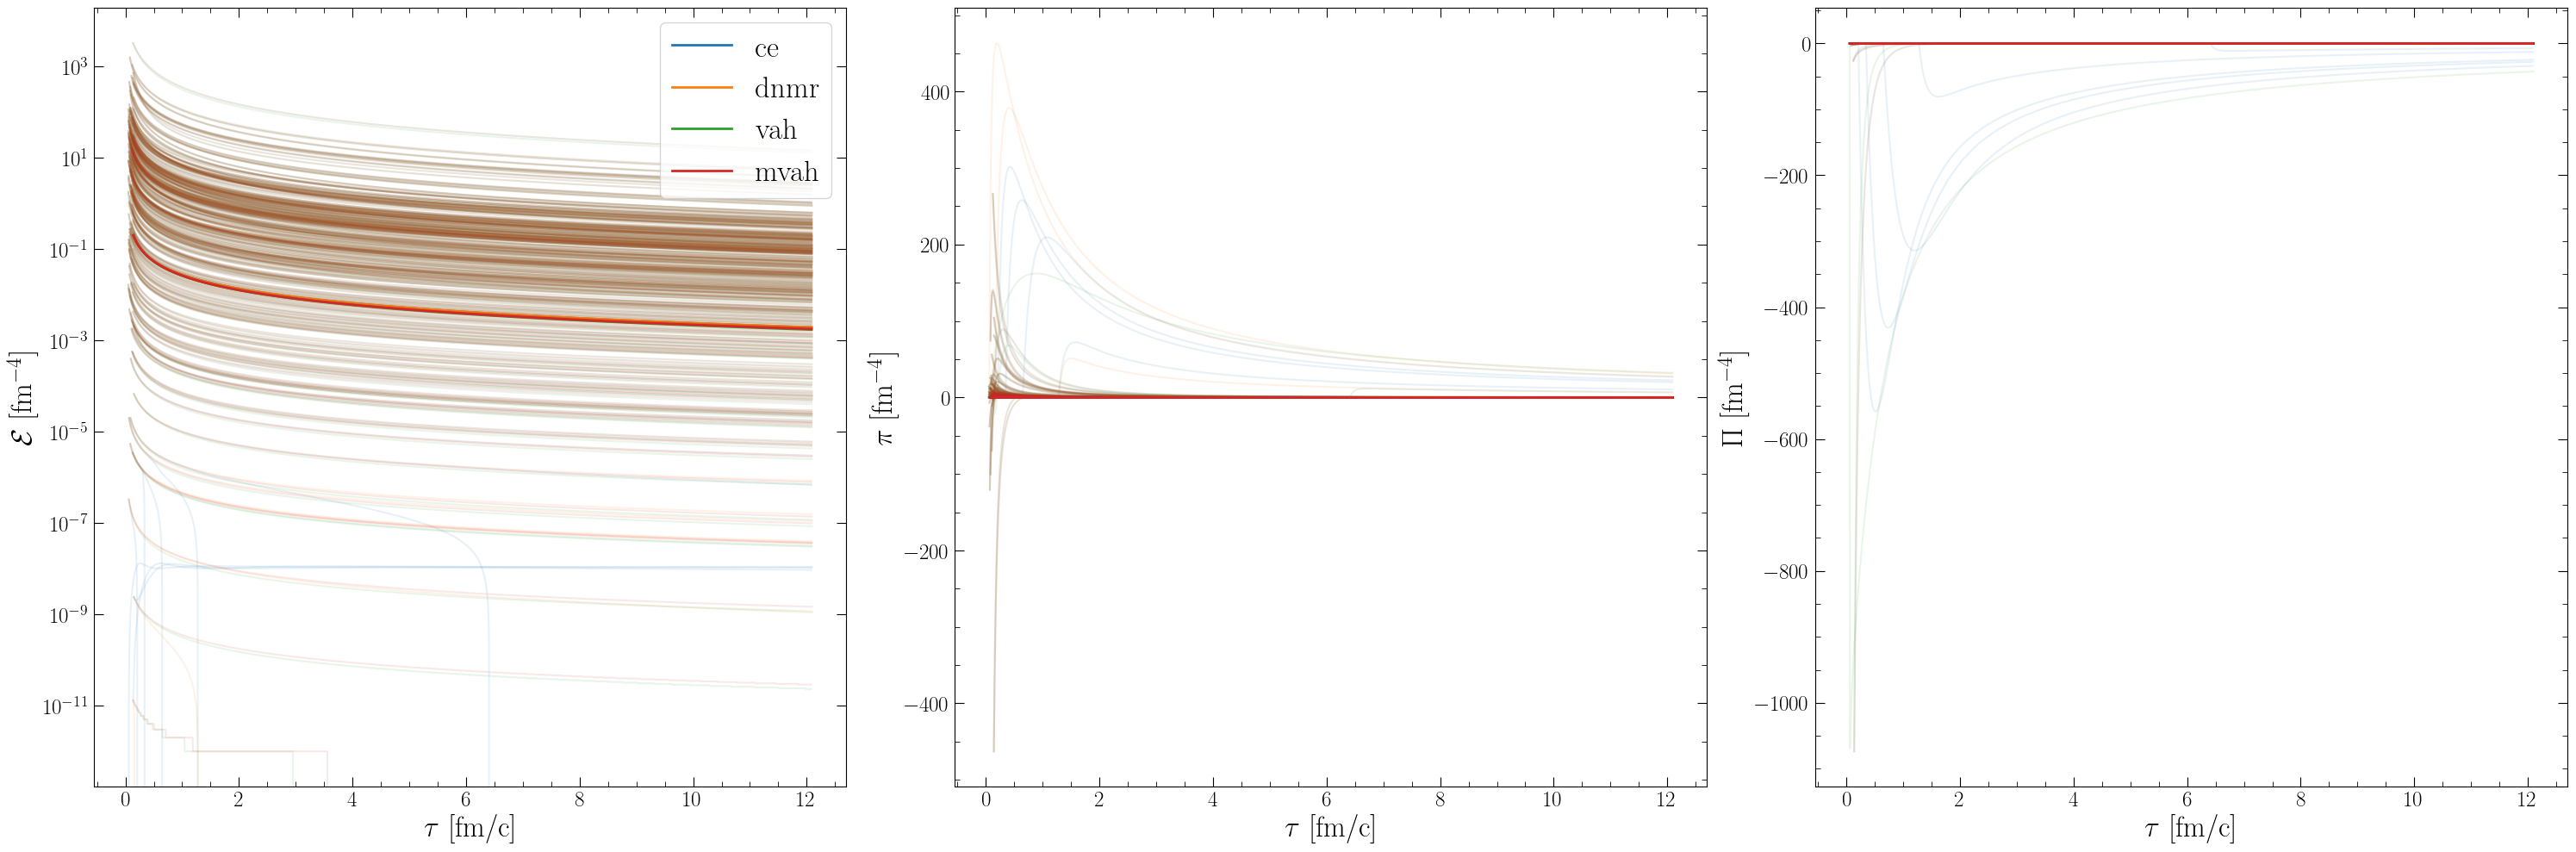

In [42]:
# make plots of total output
fig, ax = plt.subplots(1, 3, figsize=(30,10))
fig.patch.set_facecolor('white')
cmap = get_cmap(10, 'tab10')


rand_int = np.random.randint(0, num_design_points)
for i in range(3):
    for j, name in enumerate(names):
        data = np.array(full_simulations[name])
        current_step = 0
        for k in range(num_design_points):
            tau_start = GP_design_points[k][1] # starting time 
            delta_tau = tau_start / 20
            steps = int((simulation_taus[-1] - tau_start) / delta_tau)
            if k == rand_int: 
                ax[i].plot(data[current_step : current_step + steps - 1, 0], data[current_step : current_step + steps - 1, i+1], lw=2, color=cmap(j), label=name)
            else:
                ax[i].plot(data[current_step : current_step + steps - 1, 0], data[current_step : current_step + steps - 1, i+1], color=cmap(j), alpha=0.1)

            current_step += steps + 1
costumize_axis(ax[0], r'$\tau$ [fm/c]', r'$\mathcal E$ [fm$^{-4}$]')
costumize_axis(ax[1], r'$\tau$ [fm/c]', r'$\pi$ [fm$^{-4}$]')
costumize_axis(ax[2], r'$\tau$ [fm/c]', r'$\Pi$ [fm$^{-4}$]')
ax[0].set_yscale('log')
ax[0].legend(loc='upper right', fontsize=25)

fig.tight_layout()
#fig.savefig('plots/full_simulations_n=4.pdf')

In [45]:
for j, name in enumerate(names):
    print(np.any(np.isnan(hydro_lists[name])))

False
False
False
True


In [ ]:
alpha_error = 1.0
exact_error = alpha_error * exact_out[:, 1:4]
exact_pseudo = np.array([[np.random.normal(loc=obv, scale=0.05 * obv) for obv in exact] for exact in exact_out])
for i, tau in enumerate(simulation_taus):
    exact_pseudo[i, 0] = tau
exact_pseudo

array([[5.10000000e+00, 1.07432285e-01, 1.47381831e-02, 3.96494807e-04],
       [6.10000000e+00, 8.52060552e-02, 9.86714407e-03, 2.45794357e-04],
       [7.10000000e+00, 6.50936017e-02, 7.53865953e-03, 1.74110439e-04],
       [8.10000000e+00, 6.25373279e-02, 6.01706967e-03, 1.14454609e-04],
       [9.10000000e+00, 5.67917945e-02, 5.00979465e-03, 7.63396111e-05],
       [1.01000000e+01, 4.73852892e-02, 4.48120390e-03, 5.00502268e-05],
       [1.11000000e+01, 4.33631251e-02, 3.49788515e-03, 2.37420549e-05],
       [1.21000000e+01, 3.53381387e-02, 3.07614414e-03, 1.06941295e-05]])

In [13]:
emulators = {'ce': [], 'dnmr': [], 'vah': [], 'mvah': []}
read_in_emulator = False
if read_in_emulator:
    pass
else:
    for hydro in emulators:
        local_list = []
        print('\tTraining GP for ' + hydro)
        for i in range(1, 4):
            kernel = 1 * krnl.RBF(
                length_scale=GP_design_range, 
                length_scale_bounds=np.outer(np.array(GP_design_range), (1e-5, 1e2))) #+ \
                # krnl.WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-10, 1e1))
            GPR = gpr(kernel=kernel, n_restarts_optimizer=20)
            print('\t\tTraining GP:', i)
            if hydro == 'ce':
                GPR.fit(GP_design_points, ce_simulation[:,i].reshape(-1,1))
                print('GP score: {:1.3f}'.format(GPR.score(GP_design_points, ce_simulation[:,i])))
            elif hydro == 'dnmr':
                GPR.fit(GP_design_points, dnmr_simulation[:,i].reshape(-1,1))
                print('GP score: {:1.3f}'.format(GPR.score(GP_design_points, dnmr_simulation[:,i])))
            elif hydro == 'vah':
                GPR.fit(GP_design_points, vah_simulation[:,i].reshape(-1,1))
                print('GP score: {:1.3f}'.format(GPR.score(GP_design_points, vah_simulation[:,i])))
            elif hydro == 'mvah':
                GPR.fit(GP_design_points, mvah_simulation[:,i].reshape(-1,1))
                print('GP score: {:1.3f}'.format(GPR.score(GP_design_points, mvah_simulation[:,i])))
            else:
                print('Invalid hydro type')
                break
            local_list.append(GPR)
        emulators[hydro] = local_list

	Training GP for ce
		Training GP: 1


/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 71.61972439135292. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified upper bound 5

GP score: 1.000
		Training GP: 2


/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 71.61972439135292. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 2 of parameter k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 3 of parameter k2__length_scale is close to the specified upper bound 500.0. 

GP score: 1.000
		Training GP: 3
GP score: 1.000
	Training GP for dnmr
		Training GP: 1
GP score: 1.000
		Training GP: 2


/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 71.61972439135292. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified upper bound 500.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 2 of parameter k2__length_scale is close to the specified upper bound 10.0. 

GP score: 1.000
		Training GP: 3


/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 2 of parameter k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 5 of parameter k2__length_scale is close to the specified upper bound 1100.0. Increasin

GP score: 0.994
	Training GP for vah
		Training GP: 1


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
for name in emulators:
    print(name)
    for gp in emulators[name]:
        print('\t', gp.kernel.hyperparameters)
    print('\t')

## Validation

In [ ]:
#validation
number_validation_points = 10
validation_points = np.array(GP_parameter_ranges[:,0]) + np.random.rand(number_validation_points, num_parameters_in_GP) * GP_design_range
# make sure all are evaulated at same time
for i in range(number_validation_points):
    validation_points[i, 1] = validation_points[0, 1]

names = ['ce', 'dnmr','vah','mvah']

validation_data = {}
for i, name in enumerate(names):
    params['hydro_type'] = i
    validation_data[name] = ProcessHydro(GP_parameter_names, validation_points)

GP_predictions = {'ce': [], 'dnmr': [], 'vah': [], 'mvah': []}
for name in names:
    for i in range(3):
        GP_x_prediction, GP_x_err = emulators[name][i].predict(validation_points, return_std=True)
        GP_predictions[name].append(np.hstack((GP_x_prediction, GP_x_err.reshape(-1,1))))

In [ ]:
GP_predictions['ce'][2][:,1]

In [ ]:
fig, ax = plt.subplots(4, 3, figsize=(40,30))
fig.patch.set_facecolor('white')

names = ['ce', 'dnmr','vah','mvah']
observables = [r'$\mathcal E$ [fm$^{-1}$]', r'$\pi$ [fm$^{-1}$]', r'$\Pi$ [fm$^{-1}$]']
for i, name in enumerate(names):
    for j, observable in enumerate(observables):
        ax[i, j].scatter(validation_points[:,0], np.array(validation_data[name])[:, j+1], lw=2, color='blue', label=name)
        ax[i, j].fill_between(validation_points[:,0], GP_predictions[name][j][:, 0] + GP_predictions[name][j][:, 1], GP_predictions[name][j][:, 0] - GP_predictions[name][j][:, 1], color='red', alpha=0.5)
        costumize_axis(ax[i, j], r'$\eta_\mathcal S$ ', observable)
        ax[i, j].legend(loc=0, fontsize=25)
        # if j == 0:
        #     ax[i, j].set_xscale('log')
        #     ax[i, j].set_yscale('log')

In [ ]:
# Check error distribution to make sure it conforms to out assumptions
number_validation_points = 100
validation_points = np.array(GP_parameter_ranges[:,0]) + np.random.rand(number_validation_points, num_parameters_in_GP) * GP_design_range

validate = False
if validate:
    validation_data = {}
    for i, name in enumerate(names):
        params['hydro_type'] = i
        validation_data[name] = ProcessHydro(GP_parameter_names, validation_points)

    GP_predictions = {'ce': [], 'dnmr': [], 'vah': [], 'mvah': []}
    for name in names:
        for i in range(3):
            GP_x_prediction, GP_x_err = emulators[name][i].predict(validation_points, return_std=True)
            GP_predictions[name].append(np.hstack((GP_x_prediction, GP_x_err.reshape(-1,1))))

In [ ]:
if validate:
    normalized_discrepenancy = {'ce': [], 'dnmr': [], 'vah': [], 'mvah': []}
    for i, name in enumerate(names):
        for j in range(3):
            normalized_discrepenancy[name].append((GP_predictions[name][j][:,0] - np.array(validation_data[name])[:,j+1]) / GP_predictions[name][j][:,1])

    residuals = {'ce': [], 'dnmr': [], 'vah': [], 'mvah': []}
    for i, name in enumerate(names):
        for j in range(3):
            residuals[name].append((GP_predictions[name][j][:,0] - np.array(validation_data[name])[:,j+1]))

In [ ]:
if validate:
    fig1, ax1 = plt.subplots(4, 3, figsize=(40, 30))
    fig1.patch.set_facecolor('white')
    for i, name in enumerate(names):
        for j, observable in enumerate(observables):
            ax1[i, j].hist(residuals[name][j],color='brown')
            ax1[i, j].set_xlabel(observable)

    fig2, ax2 = plt.subplots(4, 3, figsize=(40, 30))
    fig2.patch.set_facecolor('white')
    for i, name in enumerate(names):
        for j, observable in enumerate(observables):
            ax2[i, j].hist(normalized_discrepenancy[name][j], bins=15, range=[-3,3], color='brown')
            ax2[i, j].set_xlabel(observable)

In [ ]:
def predict_observable(model_parameters, hydro_name, GP_emulator):
    '''
    Parameters:
    ------------
    model_parameters    - 1d-array like (n,) 
    hydro_name          - string
    GP_emulator         - dictionary
    '''
    means = []
    variances = []
    for i in range(3):
        prediction, error = GP_emulator[hydro_name][i].predict(np.array(model_parameters).reshape(-1, len(model_parameters)), return_std=True)
        means.append(prediction)
        variances.append(error ** 2)
    return np.hstack(means), np.diag(np.array(variances).flatten())

# Bayesian Inference
The usual

In [ ]:
true_parameters = GP_parameter_ranges[:,0] + np.random.rand(1) * GP_design_range
params['hydro_type'] = 4
true_observables = ProcessHydro(GP_parameter_names, true_parameters)[0]

In [ ]:
print(true_parameters)
print(true_observables)

In [ ]:
def log_prior(model_parameters, design_range):
    '''
    Parameters:
    ------------
    model_parameters    - 1d-array with shape (n,). Value of parameters used to evaluate model
    design_range        - 2d-array with shape (n,2). Give upper and lower limits of parameter values
    '''
    X  = np.array(model_parameters).reshape(1,-1)
    lower = np.all(X >= np.array(design_range)[:,0])
    upper = np.all(X <= np.array(design_range)[:,1])

    if (lower and upper):
        return 0
    else:
        return -np.inf

def log_likelihood(y, cov):
    '''
    Parameters:
    ------------
    y   - 1d-array with shape (n,)
    cov - 2d-array with shape (n,n)
    '''
    # Use Cholesky decomposition for efficient lin alg algo
    L, info = lapack.dpotrf(cov, clean=True)

    if (info < 0):
        raise print('Error occured in computation of Cholesky decomposition')

    # Solve equation L*b=y
    b, info = lapack.dpotrs(L, np.array(y))

    if (info != 0):
        raise print('Error in inverting matrix equation')

    if np.all(L.diagonal() > 0):
        return -0.5 * np.dot(y, b) - np.log(L.diagonal()).sum()
    else:
        raise print('Diagonal has negative entry')

def log_posterior(model_parameters, design_range, true_values, hydro_name, GP_emulator):
    '''
    Parameters:
    ------------
    model_parameters    - 1d-array like (n,)
    design_range        - 2d-array like (n,2)
    true_values         - 1d-array like (3,) or 2d-array like (3,2)
    hydro_name          - string containing hydro theory: 'ce', 'dnmr', 'vah', 'mvah'
    GP_emulatr          - dictionary(hydro_name: emulator_list), 
                            emulator_list[0] - energery density
                            emulator_list[1] - shear stress
                            emulator_list[2] - bulk stress
    '''
    emulation_values, emulation_error = predict_observable(model_parameters, hydro_name, GP_emulator)

    if np.array(true_values).shape != (3,2):
        y = np.array(emulation_values) - np.array(true_values)
        cov = emulation_error

    return log_prior(model_parameters, design_range) + log_likelihood(y.flatten(), cov)


In [ ]:
nparams = len(GP_parameter_names)
nwalkers = 20 * nparams
nburn = 1000
nsteps = 10000

names = ['ce', 'dnmr', 'vah', 'mvah']
MCMC_samplers = {}
for i, name in enumerate(names):
    print(f"Computing for hydro theory: {name}")
    starting_guesses = GP_parameter_ranges[:,0] + np.random.rand(nwalkers, nparams) * GP_design_range
    print("MCMC sampling using emcee (affine-invariant ensamble sampler) with {0} walkers".format(nwalkers))
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, nparams, log_posterior, args=(GP_parameter_ranges, true_observables[name][0,1:4], name, emulators))
        print('burn in sampling started')    
        pos = sampler.run_mcmc(starting_guesses, nburn, progress=True, store=True)
        print("Mean acceptance fraction: {0:.3f} (in total {1} steps)".format(
                        np.mean(sampler.acceptance_fraction), nwalkers*nburn))
        print('Burn in completed.')
        print("Now running the samples")
        sampler.run_mcmc(initial_state=None, nsteps=nsteps, progress=True, tune=False)  
        print("Mean acceptance fraction: {0:.3f} (in total {1} steps)".format(
                        np.mean(sampler.acceptance_fraction), nwalkers*nsteps))
    sampler_df = pd.DataFrame(sampler.get_chain(flat=True, discard=nburn), columns=GP_parameter_names_math)
    MCMC_samplers[name] = sampler_df

In [ ]:
GP_parameter_names_math

In [ ]:
def autocorrelation(chain, max_lag=100):
    dim = len(chain)
    acorr = np.empty(max_lag+1)
    if max_lag > dim / 5:
        print('max_lag is more than a 5th the chain length')
    
    chain1d = chain - np.average(chain)
    for lag in range(max_lag + 1):
        unshifted = None
        shifted = chain1d[lag:]
        if lag == 0:
            unshifted = chain1d
        else:
            unshifted = chain1d[:-lag]
        normalization = np.sqrt(np.dot(unshifted, unshifted))
        normalization *= np.sqrt(np.dot(shifted, shifted))
        acorr[lag] = np.dot(shifted, unshifted) / normalization
    return acorr

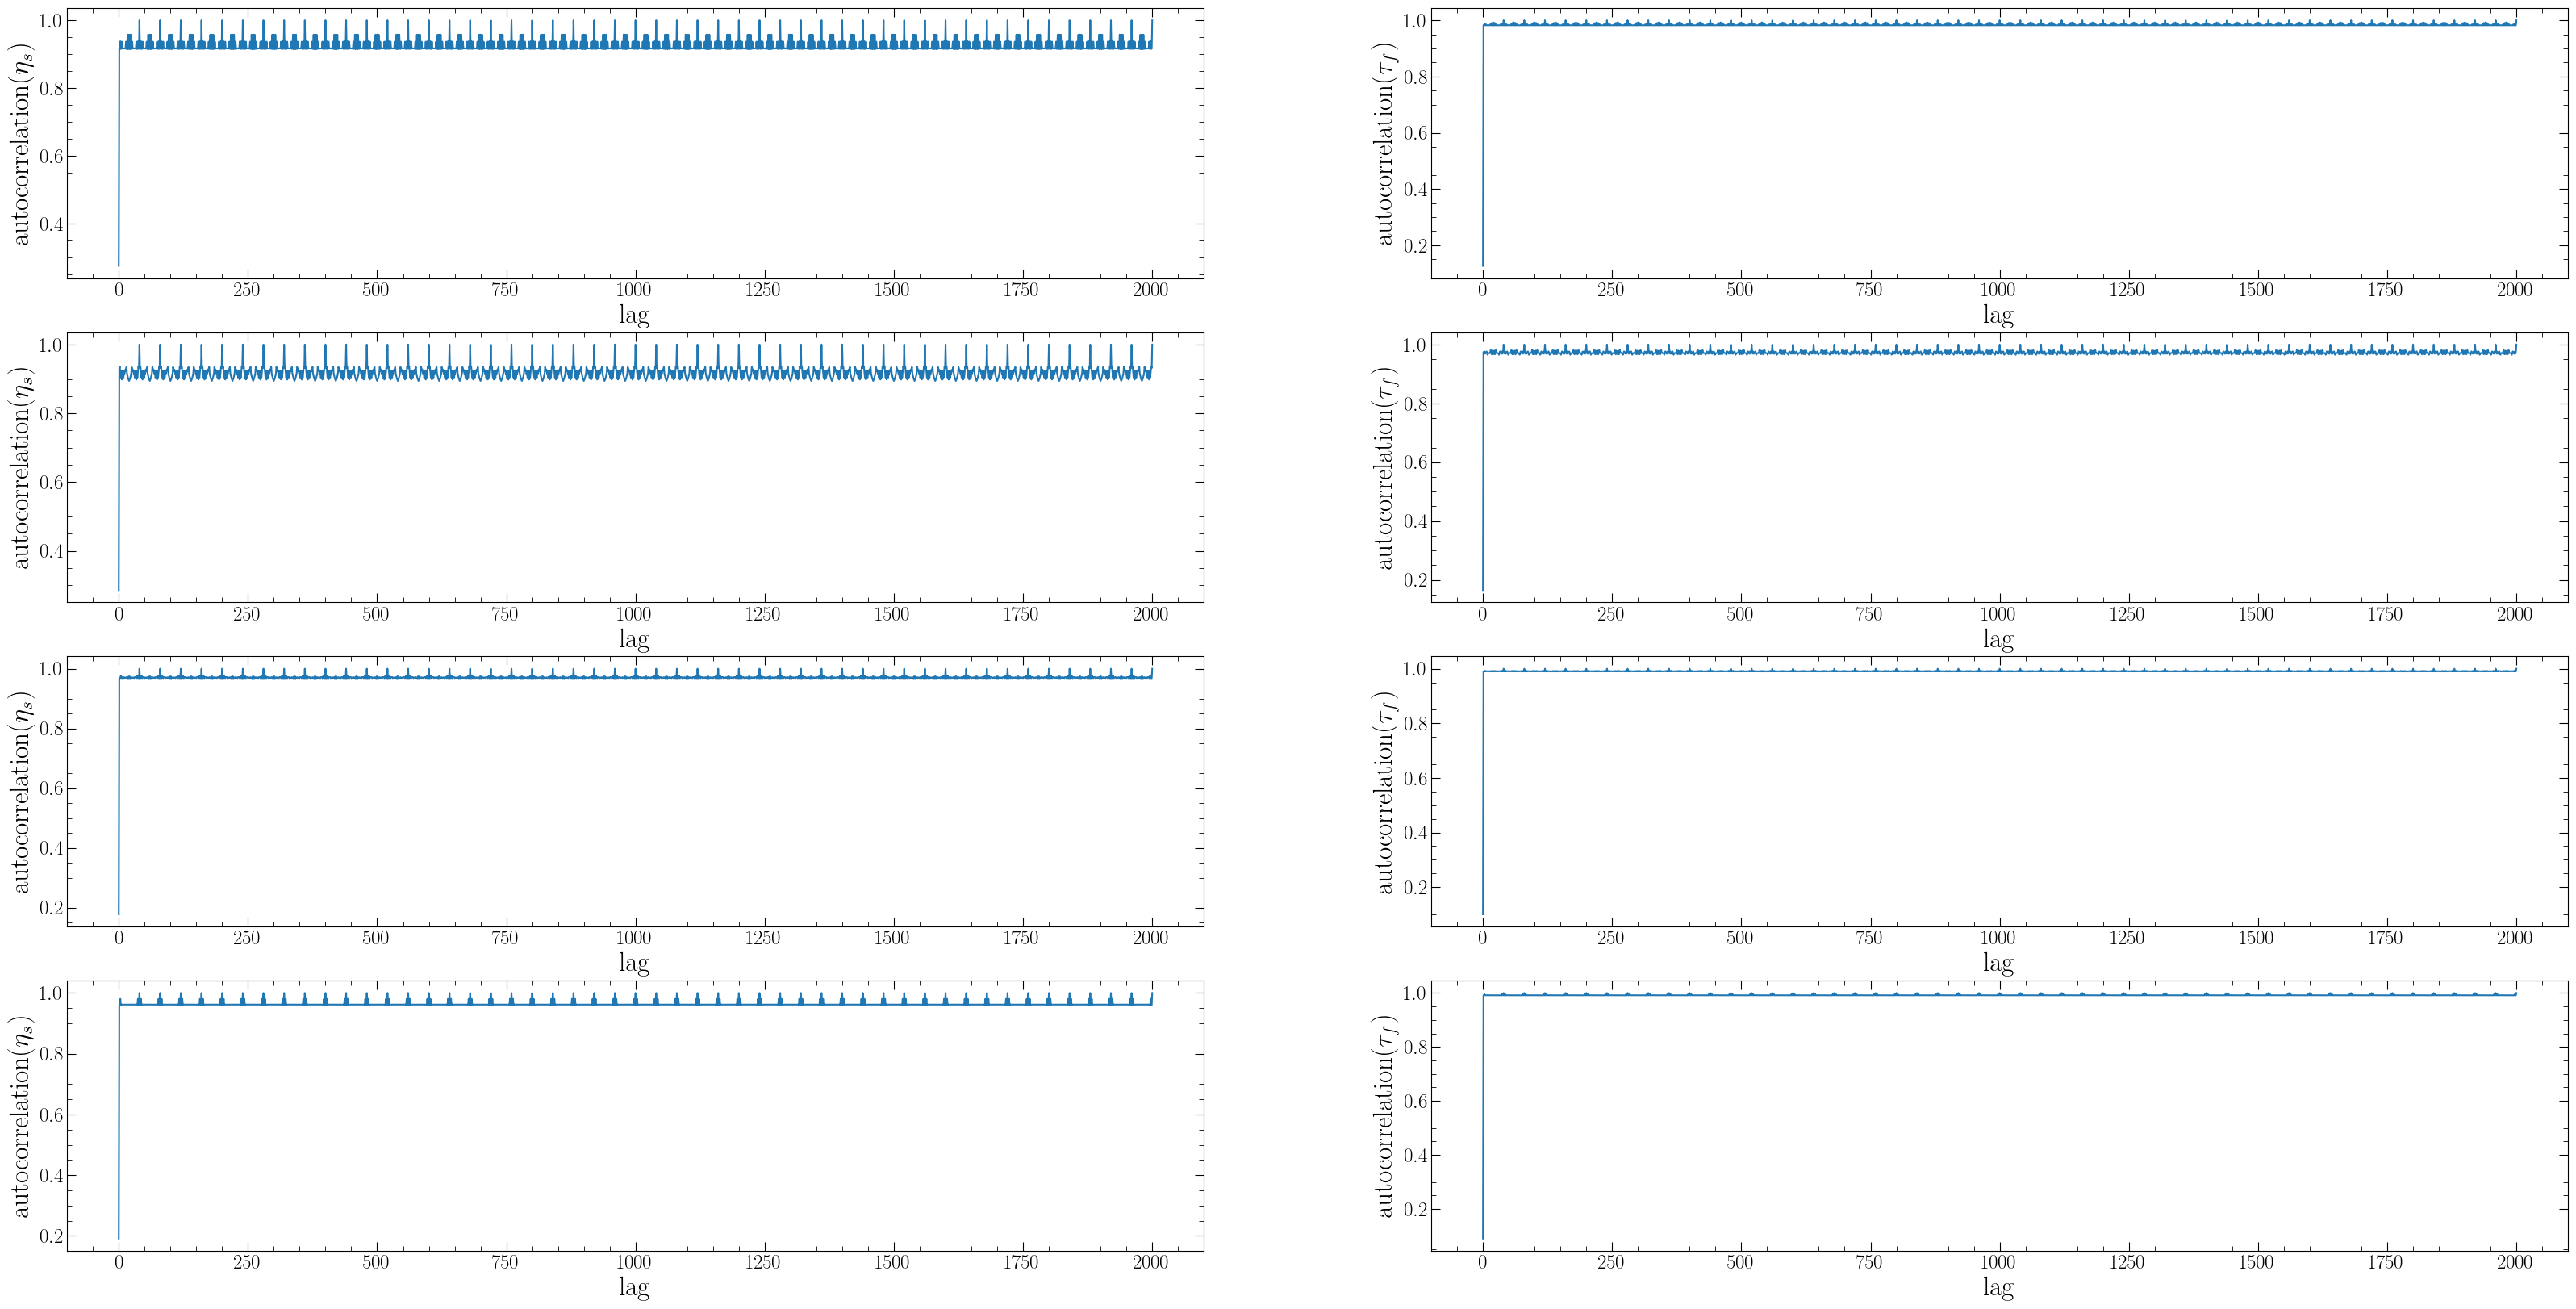

In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(40, 20))
fig.patch.set_facecolor('white')
for irow, name in enumerate(names):
    for jcol, param in enumerate(GP_parameter_names_math):
        acorr = autocorrelation(MCMC_samplers[name].iloc[:,jcol].to_numpy(), 2000)
        ax[irow, jcol].plot(acorr)
        costumize_axis(ax[irow, jcol], 'lag', 'autocorrelation(' + param + ')')
    

In [ ]:
names = ['ce', 'dnmr', 'vah', 'mvah']
for i, name in enumerate(names):
    g = sns.PairGrid(MCMC_samplers[name].iloc[:,:], corner=True, diag_sharey=False)
    g.map_lower(sns.histplot, bins=50, color=sns.color_palette()[9])
    g.map_diag(sns.kdeplot, linewidth=2, shade=True, color=sns.color_palette()[-1])
    for n in range(nparams):
        ax=g.axes[n][n]
        ax.axvline(x=true_parameters[n], ls='-', c=sns.color_palette()[3], label='Truth')
        ax.text(0,0.8,s= f'{true_parameters[n]:.2f}', transform=ax.transAxes, color=sns.color_palette()[1], fontsize=12)
    g.axes[1,1].legend(loc='best', fontsize=10)